In [8]:
!pip install femedu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.1 MB/s eta 0:00:00


CESG 504
Assignment 05

---


Topic: Plane Stress and Surface Loading

1. Reference Solution: Beam Theory

In [9]:
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

from femedu.examples import Example
from femedu.domain import System, Node
from femedu.solver import NewtonRaphsonSolver
from femedu.elements.finite import Quad
from femedu.elements.finite import Triangle
from femedu.materials import PlaneStress
from femedu.mesher import PatchMesher


In [10]:
h = 1.00      #m
b = 0.35      #m
L = 8.00      #m
M = 50e3     #Nm
E = 70e9      #Pa
v = 0.35

In [ ]:
I = (b * h**3) / 12
displacement = (M * L**2) / (2 * E * I)
rotation = (M * L) / (E * I)

print("end Displacement:", displacement, "m")
print("end Rotation:", rotation, "radians")

end Displacement: -0.0007836734693877551 m
end Rotation: -0.0001959183673469388 radians


In [ ]:
yA = -(h / 2)
yB = (h / 2)
vA = displacement + (yA * rotation)
vB = displacement + (yB * rotation)

print("in-plane displacement at node A:", vA, "m")
print("in-plane displacement at node B:", vB, "m")

in-plane displacement at node A: -0.0006857142857142858 m
in-plane displacement at node B: -0.0008816326530612245 m


In [ ]:
y = np.linspace(-h/2, h/2, 1000)  # y ranges from -h/2 to h/2
stress = (M * y) / I

# Print some sample stress values
print("Stress at y = -50cm:", stress[0], "Pa")
print("Stress at y = 0:", stress[500], "Pa")
print("Stress at y = 50cm:",stress[-1], "Pa")

Stress at y = -50cm: 857142.8571428573 Pa
Stress at y = 0: -858.0008580009339 Pa
Stress at y = 50cm: -857142.8571428573 Pa


2. Convergence Study 1

In [ ]:
class BeamAnalysis:

    def set_boundary_conditions(nodes, L):
        for node in nodes:
            xNd = node.getPos()
            if np.isclose(xNd[0], 0):
                node.fixDOF(['ux', 'uy'])
        return None

    def apply_loads(nodes, L, h, M):
        end_nodes = [node for node in nodes if np.isclose(node.getPos()[0], L)]

        for node in end_nodes:
            for elem in node.elements:
                for face in elem.faces:
                    for x, area in zip(face.pos, face.area):
                        Xo = np.array([L, 0.0])
                        No = np.array([1.0, 0.0])
                        if np.abs((x - Xo) @ No) < 1.0e-2 and No @ area / np.linalg.norm(area):
                            y = (x - Xo)[1]
                            V = M / (h ** 3 / 12) * y
                            face.setLoad(V, 0.0)


    def solve(L, h, E, v, b, M, Nx=[4, 8, 16], Ny=[2, 4, 8]):

        convDisp = []
        convN = []

        for Nx, Ny in zip(Nx, Ny):
            print(f"mesh with {Nx} elements along x")
            print(f"mesh with {Ny} elements along y")

            model = System()
            model.setSolver(NewtonRaphsonSolver())

            mesher = PatchMesher(model, (0., -h / 2), (L, -h / 2), (L, h / 2), (0., h / 2))
            nodes, elements = mesher.quadMesh(Nx, Ny, Quad, PlaneStress({'E': E, 'v': v, 'b': b}))

            BeamAnalysis.set_boundary_conditions(nodes, L)
            BeamAnalysis.apply_loads(nodes, L, h, M)
            model.solve()

            print(nodes[-1].getDisp())
            convN.append(Nx)
            convDisp.append(nodes[-1].getDisp(['uy']))


            model.plot(factor=1000.0, filename=f"beam_deformed_Nx{Nx}.png", show_bc=True, show_loads=True)


mesh with 4 elements along x
mesh with 2 elements along y
+
[ 5.19298942e-05 -5.19482951e-04]


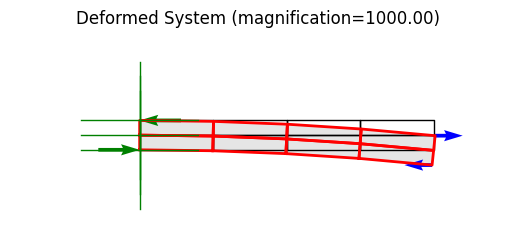

mesh with 8 elements along x
mesh with 4 elements along y
+
[ 0.00014977 -0.00150332]


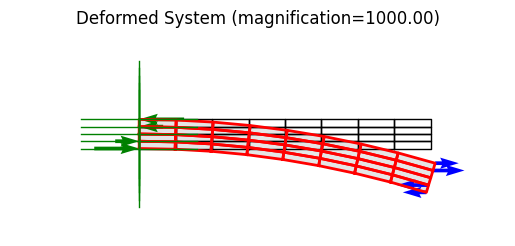

mesh with 16 elements along x
mesh with 8 elements along y
+
[ 0.00023429 -0.00235254]


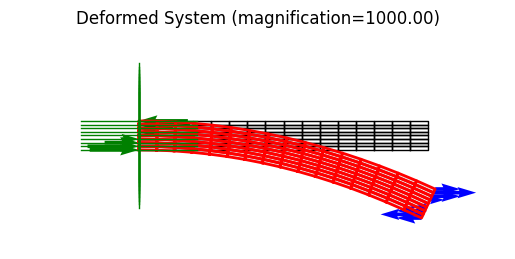

In [ ]:
if __name__ == "__main__":
    BeamAnalysis.solve(L, h, E, v, b, M)

In [48]:
class BeamAnalysis:

    def set_boundary_conditions(nodes, L):
        for node in nodes:
            xNd = node.getPos()
            if np.isclose(xNd[0], 0):
                node.fixDOF(['ux', 'uy'])
        return None

    def apply_loads(nodes, L, h, M):
        end_nodes = [node for node in nodes if np.isclose(node.getPos()[0], L)]

        for node in end_nodes:
            for elem in node.elements:
                for face in elem.faces:
                    for x, area in zip(face.pos, face.area):
                        Xo = np.array([L, 0.0])
                        No = np.array([1.0, 0.0])
                        if np.abs((x - Xo) @ No) < 1.0e-2 and No @ area / np.linalg.norm(area):
                            y = (x - Xo)[1]
                            V = M / (h ** 3 / 12) * y
                            face.setLoad(V, 0.0)


    def solve(L, h, E, v, b, M, target_load_level=1.0, max_steps=10, Nx=[4, 8, 16], Ny=[2, 4, 8]):

        convDisp = []
        convN = []

        for Nx, Ny in zip(Nx, Ny):
            print(f"mesh with {Nx} elements along x")
            print(f"mesh with {Ny} elements along y")

            model = System()
            model.setSolver(NewtonRaphsonSolver())

            mesher = PatchMesher(model, (0., -h / 2), (L, -h / 2), (L, h / 2), (0., h / 2))
            nodes, elements = mesher.quadMesh(Nx, Ny, Quad, PlaneStress({'E': E, 'v': v, 'b': b}))

            BeamAnalysis.set_boundary_conditions(nodes, L)
            BeamAnalysis.apply_loads(nodes, L, h, M)
            model.solve()

            print(nodes[-1].getDisp())
            convN.append(Nx)
            convDisp.append(nodes[-1].getDisp(['uy']))

            end_node = nodes[-1]
            model.initRecorder(variables=['ux', 'uy'], nodes=[end_node])
            model.startRecorder()


            for lf in np.linspace(0.0, target_load_level, max_steps):
                model.setLoadFactor(lf)
                model.solve(verbose=True)

            model.plot(factor=1000.0, filename=f"plate11_deformed_lf{lf:.2f}.png", show_bc=1, show_loads=1, show_reactions=1)


            model.historyPlot('lam', ['ux', 'uy'], nodes=[end_node, end_node])
            model.historyPlot(('ux', end_node), 'uy', node=end_node)

mesh with 4 elements along x
mesh with 2 elements along y
+
[ 8.57103096e-06 -6.85714940e-05]
norm of the out-of-balance force:   5.3033e+04
norm of the out-of-balance force:   2.2809e+01
norm of the out-of-balance force:   1.3555e-04
norm of the out-of-balance force:   1.2498e-04
norm of the out-of-balance force:   3.3079e-04
norm of the out-of-balance force:   2.4755e-04
norm of the out-of-balance force:   1.1616e-04
norm of the out-of-balance force:   1.6816e-04
norm of the out-of-balance force:   1.8298e-04
norm of the out-of-balance force:   1.3133e-04
+
norm of the out-of-balance force:   5.8926e+03
norm of the out-of-balance force:   2.8156e-01
norm of the out-of-balance force:   1.5197e-04
norm of the out-of-balance force:   2.1507e-04
norm of the out-of-balance force:   2.5792e-04
norm of the out-of-balance force:   1.5809e-04
norm of the out-of-balance force:   1.2042e-04
norm of the out-of-balance force:   1.6554e-04
norm of the out-of-balance force:   1.2684e-04
norm of the

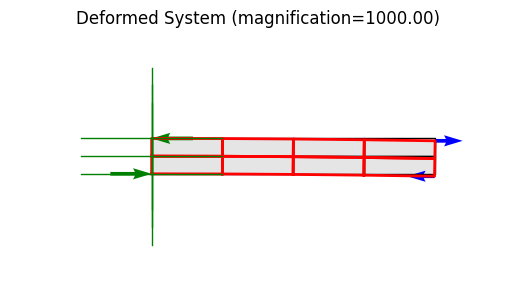

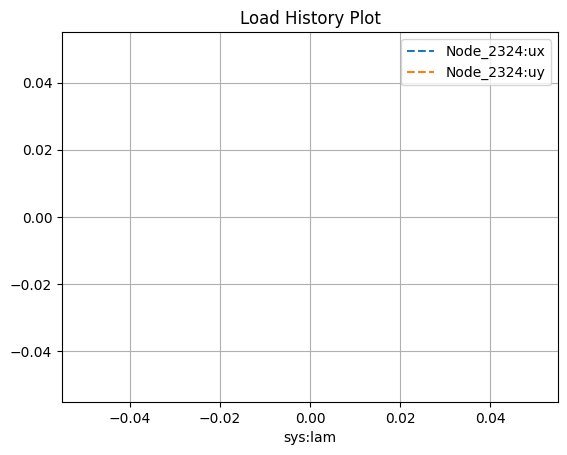

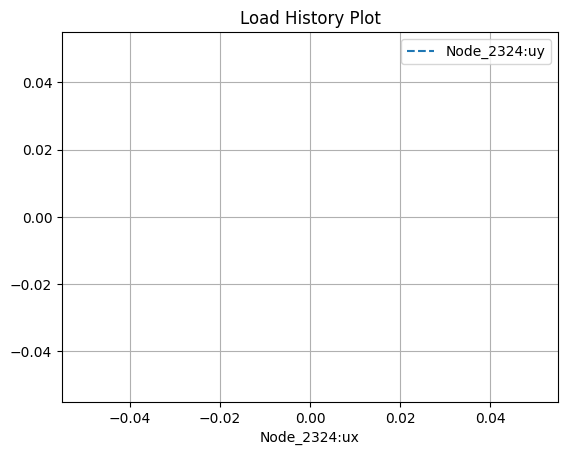

mesh with 8 elements along x
mesh with 4 elements along y
+
[ 2.13477489e-05 -1.71359893e-04]
norm of the out-of-balance force:   6.6291e+04
norm of the out-of-balance force:   1.0993e+02
norm of the out-of-balance force:   3.1360e-04
norm of the out-of-balance force:   3.0234e-04
norm of the out-of-balance force:   4.6141e-04
norm of the out-of-balance force:   4.1012e-04
norm of the out-of-balance force:   3.8328e-04
norm of the out-of-balance force:   3.4655e-04
norm of the out-of-balance force:   5.6428e-04
norm of the out-of-balance force:   3.5236e-04
+
norm of the out-of-balance force:   7.3657e+03
norm of the out-of-balance force:   1.3572e+00
norm of the out-of-balance force:   4.2380e-04
norm of the out-of-balance force:   3.5938e-04
norm of the out-of-balance force:   4.6282e-04
norm of the out-of-balance force:   3.7979e-04
norm of the out-of-balance force:   3.1382e-04
norm of the out-of-balance force:   3.4823e-04
norm of the out-of-balance force:   4.3676e-04
norm of the

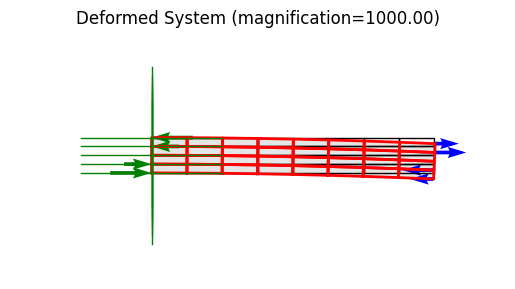

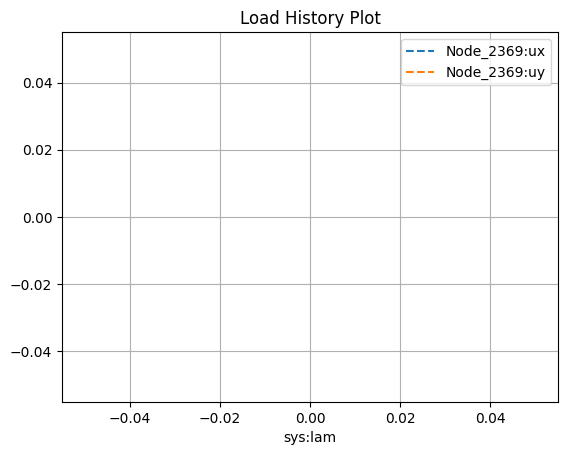

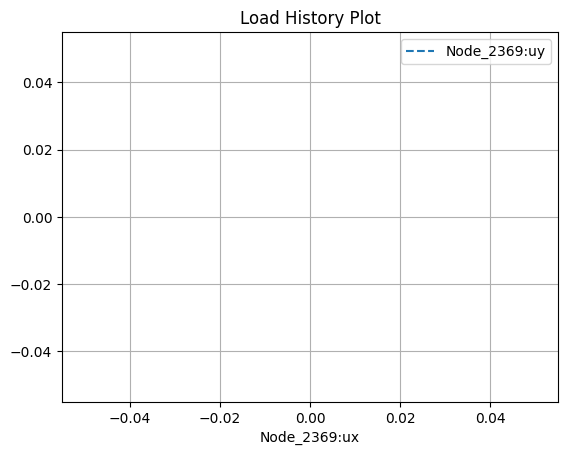

mesh with 16 elements along x
mesh with 8 elements along y
+
[ 2.99094945e-05 -2.39941759e-04]
norm of the out-of-balance force:   5.4766e+04
norm of the out-of-balance force:   1.5916e+02
norm of the out-of-balance force:   8.2254e-04
norm of the out-of-balance force:   7.2878e-04
norm of the out-of-balance force:   8.0004e-04
norm of the out-of-balance force:   9.4955e-04
norm of the out-of-balance force:   7.6360e-04
norm of the out-of-balance force:   8.5130e-04
norm of the out-of-balance force:   8.3940e-04
norm of the out-of-balance force:   9.3682e-04
+
norm of the out-of-balance force:   6.0851e+03
norm of the out-of-balance force:   1.9649e+00
norm of the out-of-balance force:   8.5834e-04
norm of the out-of-balance force:   8.1782e-04
norm of the out-of-balance force:   7.2723e-04
norm of the out-of-balance force:   9.3227e-04
norm of the out-of-balance force:   7.6629e-04
norm of the out-of-balance force:   6.8120e-04
norm of the out-of-balance force:   8.6237e-04
norm of th

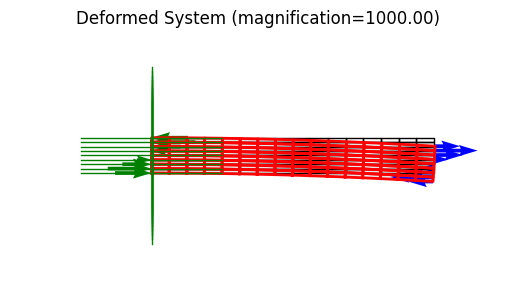

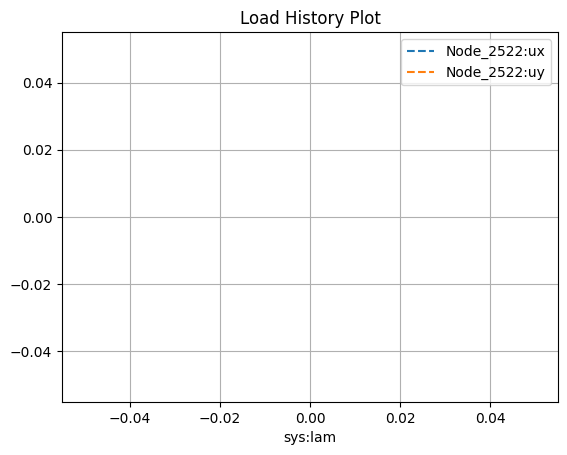

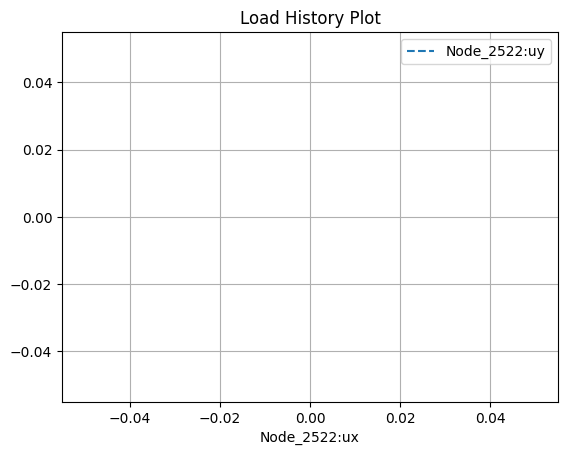

In [49]:
if __name__ == "__main__":
    BeamAnalysis.solve(L, h, E, v, b, M)

3. Convergence Study 2

+
[3.42854939e-05 1.86521548e-15]


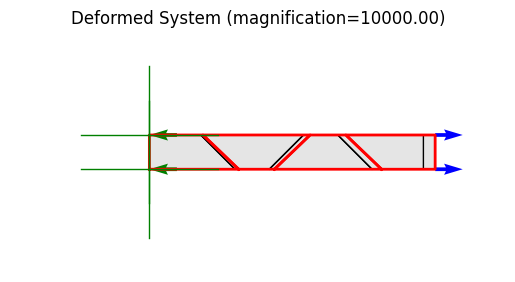

In [ ]:
class BeamAnalysis:

    def set_boundary_conditions(nodes, L):
        for node in nodes:
            xNd = node.getPos()
            if np.isclose(xNd[0], 0):
                node.fixDOF(['ux', 'uy'])
        return None

    def apply_loads(nodes, L, h, M):
        end_nodes = [node for node in nodes if np.isclose(node.getPos()[0], L)]

        for node in end_nodes:
            for elem in node.elements:
                for face in elem.faces:
                    for x, area in zip(face.pos, face.area):
                        Xo = np.array([L, 0.0])
                        No = np.array([1.0, 0.0])
                        if np.abs((x - Xo) @ No) < 1.0e-2 and No @ area / np.linalg.norm(area):
                            y = (x - Xo)[1]
                            V = M / (h ** 3 / 12) * y
                            face.setLoad(V, 0.0)

    def solve(nodes, elements, L, h, M, Nx=[4, 8, 16], Ny=[2, 4, 8]):
        convDisp = []
        convN = []

        model = System()
        model.setSolver(NewtonRaphsonSolver())

        model.addNode(*nodes)
        model.addElement(*elements)

        BeamAnalysis.set_boundary_conditions(nodes, L)
        BeamAnalysis.apply_loads(nodes, L, h, M)
        model.solve()

        print(nodes[-1].getDisp())
        convDisp.append(nodes[-1].getDisp(['uy']))


        model.plot(factor=10000.0, filename="beam_deformed.png", show_bc=True, show_loads=True)


if __name__ == "__main__":
    nodes = (
        Node(0.0, 0.0),
        Node(2.5, 0.0),
        Node(3.5, 0.0),
        Node(6.5, 0.0),
        Node(L, 0.0),
        Node(0.0, h),
        Node(1.5, h),
        Node(4.5, h),
        Node(5.5, h),
        Node(L, h),
    )

    elements = (
        Quad(nodes[0], nodes[1], nodes[6], nodes[5], PlaneStress({'E': E, 'v': v, 'b': b})),
        Quad(nodes[1], nodes[2], nodes[7], nodes[6], PlaneStress({'E': E, 'v': v, 'b': b})),
        Quad(nodes[2], nodes[3], nodes[8], nodes[7], PlaneStress({'E': E, 'v': v, 'b': b})),
        Quad(nodes[3], nodes[4], nodes[9], nodes[8], PlaneStress({'E': E, 'v': v, 'b': b})),
    )

    BeamAnalysis.solve(nodes, elements, L, h, M)


In [52]:
class BeamAnalysis:

    def set_boundary_conditions(nodes, L):
        for node in nodes:
            xNd = node.getPos()
            if np.isclose(xNd[0], 0):
                node.fixDOF(['ux', 'uy'])
        return None

    def apply_loads(nodes, L, h, M):
        end_nodes = [node for node in nodes if np.isclose(node.getPos()[0], L)]

        for node in end_nodes:
            for elem in node.elements:
                for face in elem.faces:
                    for x, area in zip(face.pos, face.area):
                        Xo = np.array([L, 0.0])
                        No = np.array([1.0, 0.0])
                        if np.abs((x - Xo) @ No) < 1.0e-2 and No @ area / np.linalg.norm(area):
                            y = (x - Xo)[1]
                            V = M / (h ** 3 / 12) * y
                            face.setLoad(V, 0.0)

    def solve(L, h, E, v, b, M, target_load_level=1.0, max_steps=10, Nx=[4, 8, 16], Ny=[2, 4, 8]):
        convDisp = []
        convN = []

        for Nx, Ny in zip(Nx, Ny):
            print(f"mesh with {Nx} elements along x")
            print(f"mesh with {Ny} elements along y")

            model = System()
            model.setSolver(NewtonRaphsonSolver())

            initial_nodes = [
                Node(0.0, 0.0),
                Node(2.5, 0.0),
                Node(3.5, 0.0),
                Node(6.5, 0.0),
                Node(L, 0.0),
                Node(0.0, h),
                Node(1.5, h),
                Node(4.5, h),
                Node(5.5, h),
                Node(L, h),
            ]

            initial_elements = [
                Quad(initial_nodes[0], initial_nodes[1], initial_nodes[6], initial_nodes[5], PlaneStress({'E': E, 'v': v, 'b': b})),
                Quad(initial_nodes[1], initial_nodes[2], initial_nodes[7], initial_nodes[6], PlaneStress({'E': E, 'v': v, 'b': b})),
                Quad(initial_nodes[2], initial_nodes[3], initial_nodes[8], initial_nodes[7], PlaneStress({'E': E, 'v': v, 'b': b})),
                Quad(initial_nodes[3], initial_nodes[4], initial_nodes[9], initial_nodes[8], PlaneStress({'E': E, 'v': v, 'b': b})),
            ]

            mesher = PatchMesher(model, (0., -h / 2), (L, -h / 2), (L, h / 2), (0., h / 2))
            refined_nodes, refined_elements = mesher.quadMesh(Nx, Ny, Quad, PlaneStress({'E': E, 'v': v, 'b': b}))


            nodes = initial_nodes + refined_nodes
            elements = initial_elements + refined_elements

            model.addNode(*nodes)
            model.addElement(*elements)

            BeamAnalysis.set_boundary_conditions(nodes, L)
            BeamAnalysis.apply_loads(nodes, L, h, M)
            model.solve()

            print(nodes[-1].getDisp())
            convN.append(Nx)
            convDisp.append(nodes[-1].getDisp(['uy']))



            end_node = nodes[-1]
            model.initRecorder(variables=['ux', 'uy'], nodes=[end_node])
            model.startRecorder()


            for lf in np.linspace(0.0, target_load_level, max_steps):
                model.setLoadFactor(lf)
                model.solve(verbose=True)

            model.plot(factor=1000.0, filename=f"plate11_deformed_lf{lf:.2f}.png", show_bc=1, show_loads=1, show_reactions=1)


            model.historyPlot('lam', ['ux', 'uy'], nodes=[end_node, end_node])
            model.historyPlot(('ux', end_node), 'uy', node=end_node)


mesh with 4 elements along x
mesh with 2 elements along y
addNode: node Node_2558 already exists in system and was not added again
addNode: node Node_2559 already exists in system and was not added again
addNode: node Node_2560 already exists in system and was not added again
addNode: node Node_2561 already exists in system and was not added again
addNode: node Node_2562 already exists in system and was not added again
addNode: node Node_2563 already exists in system and was not added again
addNode: node Node_2564 already exists in system and was not added again
addNode: node Node_2565 already exists in system and was not added again
addNode: node Node_2566 already exists in system and was not added again
addNode: node Node_2567 already exists in system and was not added again
addNode: node Node_2568 already exists in system and was not added again
addNode: node Node_2569 already exists in system and was not added again
addNode: node Node_2570 already exists in system and was not added

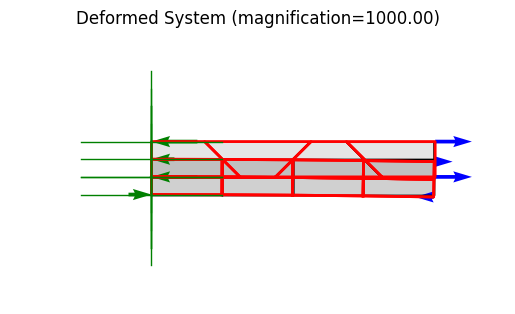

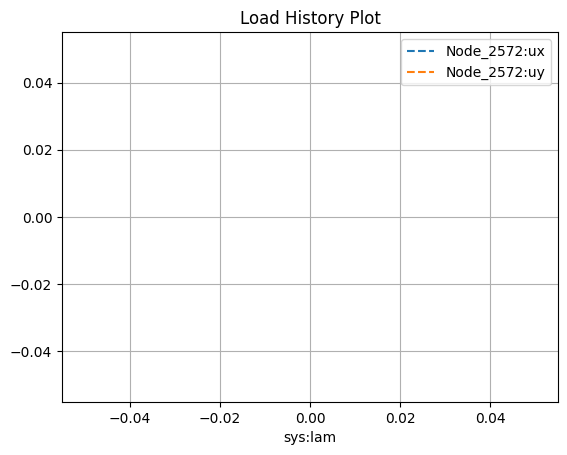

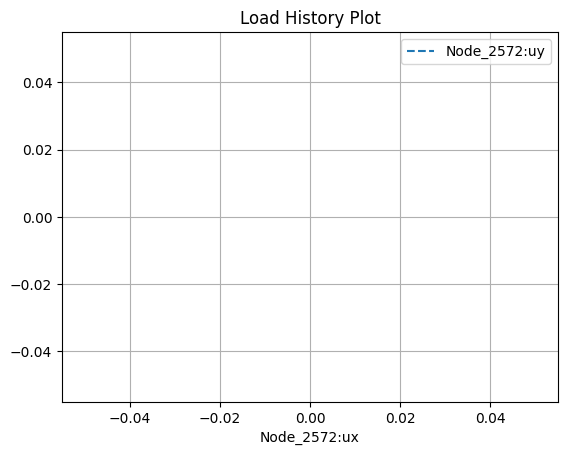

mesh with 8 elements along x
mesh with 4 elements along y
addNode: node Node_2583 already exists in system and was not added again
addNode: node Node_2584 already exists in system and was not added again
addNode: node Node_2585 already exists in system and was not added again
addNode: node Node_2586 already exists in system and was not added again
addNode: node Node_2587 already exists in system and was not added again
addNode: node Node_2588 already exists in system and was not added again
addNode: node Node_2589 already exists in system and was not added again
addNode: node Node_2590 already exists in system and was not added again
addNode: node Node_2591 already exists in system and was not added again
addNode: node Node_2592 already exists in system and was not added again
addNode: node Node_2593 already exists in system and was not added again
addNode: node Node_2594 already exists in system and was not added again
addNode: node Node_2595 already exists in system and was not added

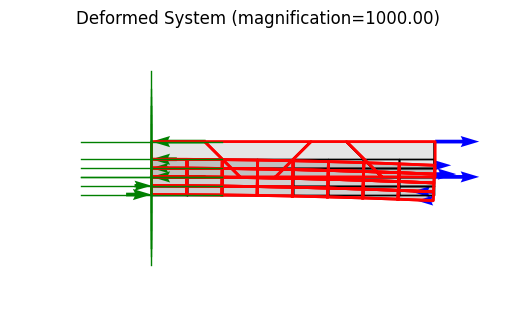

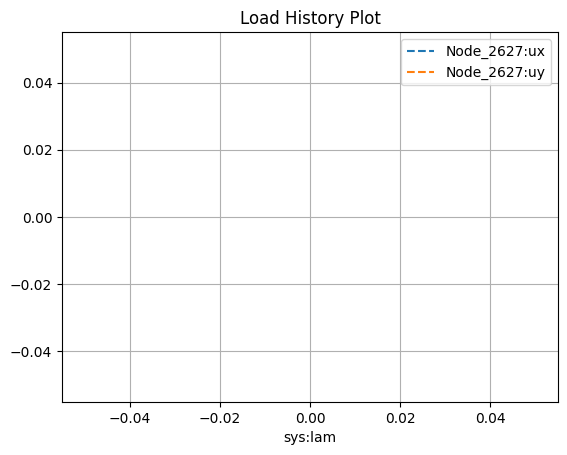

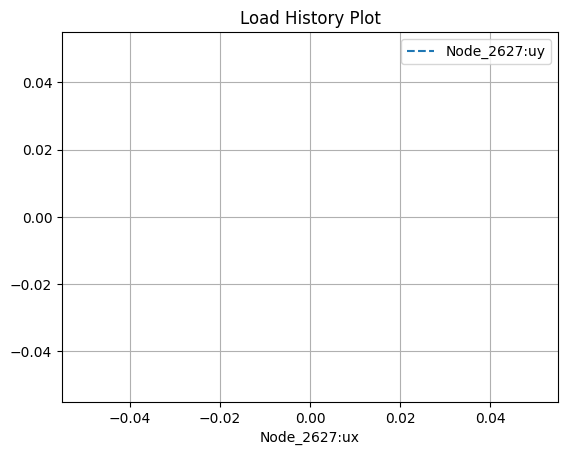

mesh with 16 elements along x
mesh with 8 elements along y
addNode: node Node_2638 already exists in system and was not added again
addNode: node Node_2639 already exists in system and was not added again
addNode: node Node_2640 already exists in system and was not added again
addNode: node Node_2641 already exists in system and was not added again
addNode: node Node_2642 already exists in system and was not added again
addNode: node Node_2643 already exists in system and was not added again
addNode: node Node_2644 already exists in system and was not added again
addNode: node Node_2645 already exists in system and was not added again
addNode: node Node_2646 already exists in system and was not added again
addNode: node Node_2647 already exists in system and was not added again
addNode: node Node_2648 already exists in system and was not added again
addNode: node Node_2649 already exists in system and was not added again
addNode: node Node_2650 already exists in system and was not adde

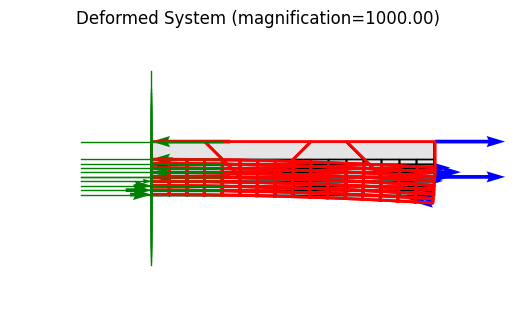

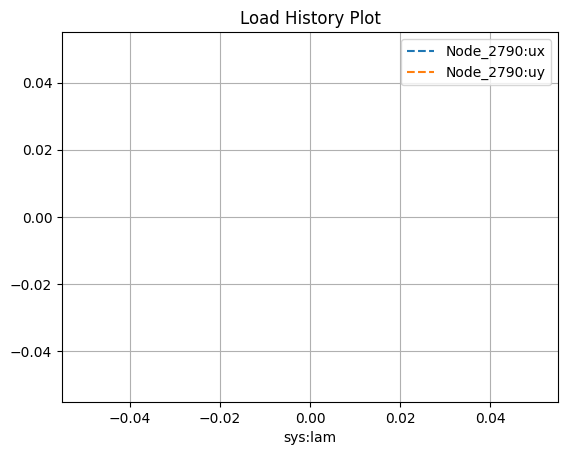

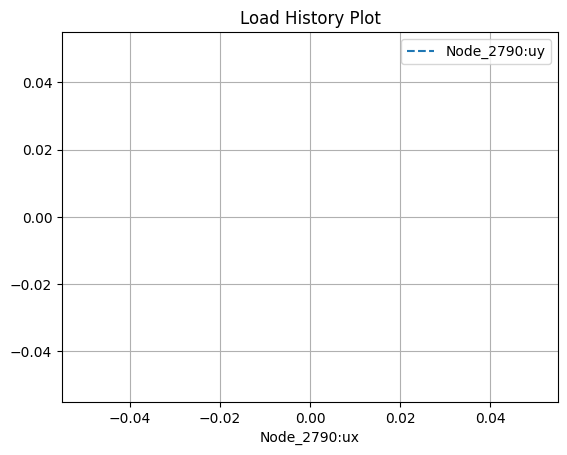

In [53]:
if __name__ == "__main__":
    BeamAnalysis.solve(L, h, E, v, b, M)

4. Summary and Conclusions